In [1]:
from fasttext import load_model
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

In [2]:
datafile_path = '/media/disk2/vtretyak/wiktionary_data0.json'
data = pd.read_json(datafile_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782341 entries, 0 to 782340
Data columns (total 5 columns):
title        782341 non-null object
POS          782341 non-null object
meanings     782341 non-null object
relations    782341 non-null object
phraseme     782341 non-null object
dtypes: object(5)
memory usage: 35.8+ MB


In [4]:
def get_only_meanings(list_means_exmpls):
    return [mean[0] for mean in list_means_exmpls if len(mean[0])]

In [5]:
data['mean_only'] = data.meanings.apply(get_only_meanings)

In [6]:
dataset = data[['title', 'mean_only']]

In [7]:
lst_col = 'mean_only'

repeats = np.repeat(dataset['title'].values, dataset[lst_col].str.len())

concats = [x for inner in dataset[lst_col] for x in inner]

assert len(repeats) == len(concats)

In [8]:
dataset = pd.DataFrame({'title': repeats, 'meaning': concats})

In [9]:
dataset.head()

,title,meaning
0,Фемиксира,согласно легендам греческой мифологии — город ...
1,эбонитовый,произведённый из эбонита
2,эбонитовый,очень чёрный
3,а,название первой буквы русского алфавита или зв...
4,а,"нечто первое в ряду аналогичных предметов, пун..."


In [10]:
del data

In [11]:
ft_model = load_model('/media/disk2/vtretyak/cc.ru.300.bin')

In [12]:
#TODO: add preprocessed 
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [13]:
def text_to_vector(text, window_length=30):
    """
    Given a string, normalizes it, then splits it into words and finally converts
    it to a sequence of word vectors.
    """
    n_features = ft_model.get_dimension()
    text = normalize(text)
    words = text.split()
    window = words[-window_length:]
      
    x = np.zeros((window_length, n_features))

    for i, word in enumerate(window):
        x[i, :] = ft_model.get_word_vector(word).astype('float32')

    return x

In [14]:
window_length = 30
batch_size = 10
dataset_size = 5000

#TODO: wrap to function, positive sample
X_positive = np.zeros((dataset_size, window_length, 300), dtype='float32')
for i, mean in enumerate(dataset['meaning'].values[:dataset_size]):
    X_positive[i, :] = text_to_vector(mean)
    
y_positive = np.zeros((dataset_size, window_length, 300), dtype='float32')
for i, title in enumerate(dataset['title'].values[:dataset_size]):
    y_positive[i, :] = text_to_vector(title)

In [16]:
X_negative = np.zeros((dataset_size, window_length, 300), dtype='float32')
for i, mean in enumerate(dataset['meaning'].sample(n=dataset_size).values):
    X_negative[i, :] = text_to_vector(mean)
    
y_negative = np.zeros((dataset_size, window_length, 300), dtype='float32')
for i, title in enumerate(dataset['title'].sample(n=dataset_size).values):
    y_negative[i, :] = text_to_vector(title)

In [17]:
print(X_positive.shape,y_positive.shape)
print(X_negative.shape,y_negative.shape)

(5000, 30, 300) (5000, 30, 300)
(5000, 30, 300) (5000, 30, 300)


In [18]:
X_meanings = np.concatenate((X_positive, X_negative), axis=0)
X_titles = np.concatenate((y_positive, y_negative), axis=0)
y = np.concatenate((np.ones(shape=(X_positive.shape[0])), 
                    np.zeros(shape=X_negative.shape[0])), axis=0)

print(X_meanings.shape, X_titles.shape, y.shape)

(10000, 30, 300) (10000, 30, 300) (10000,)


In [19]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Add
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [20]:
inputs_title = Input(batch_shape=(batch_size, 30, 300))
inputs_meaning = Input(batch_shape=(batch_size, 30, 300))

lstm_1 = LSTM(100, dropout=0.2)(inputs_title)
lstm_2 = LSTM(100, dropout=0.2)(inputs_meaning)

concat = Add()([lstm_1, lstm_2])

dense_classification = Dense(1, activation='sigmoid')(concat)

model = Model(inputs=[inputs_title, inputs_meaning], outputs=dense_classification)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (10, 30, 300)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (10, 30, 300)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (10, 100)            160400      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (10, 100)            160400      input_2[0][0]                    
____________________________________________________________________________________________

In [22]:
history = model.fit([X_meanings, X_titles], y,
          epochs=30, batch_size=batch_size, validation_split=0.3)

Train on 7000 samples, validate on 3000 samples
Epoch 1/30
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3884 - accuracy: 0.8499 - val_loss: 0.6303 - val_accuracy: 0.7597
Epoch 2/30
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3333 - accuracy: 0.8740 - val_loss: 0.5854 - val_accuracy: 0.7657
Epoch 3/30
7000/7000 [==============================] - 14s 2ms/step - loss: 0.3238 - accuracy: 0.8750 - val_loss: 0.7523 - val_accuracy: 0.7660
Epoch 4/30
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3148 - accuracy: 0.8804 - val_loss: 0.8513 - val_accuracy: 0.6547
Epoch 5/30
7000/7000 [==============================] - 15s 2ms/step - loss: 0.3056 - accuracy: 0.8833 - val_loss: 0.6772 - val_accuracy: 0.7107
Epoch 6/30
7000/7000 [==============================] - 15s 2ms/step - loss: 0.2900 - accuracy: 0.8927 - val_loss: 0.5691 - val_accuracy: 0.8170
Epoch 7/30
7000/7000 [==============================] - 15s 2ms/step - loss: 0.279

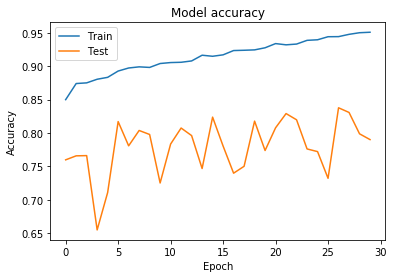

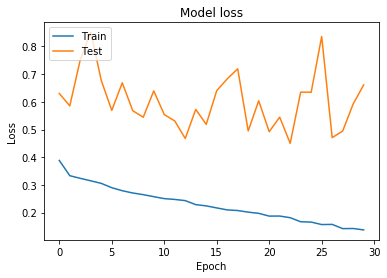

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()